# Deep Learning & Art: Neural Style Transfer

This is a project conducted as part of the Deep Learning Specialization.

The original implementation used keras; However, an adapted Pytorch version is explored here created by [furkanu](https://github.com/furkanu/deeplearning.ai-pytorch/tree/master/4-%20Convolutional%20Neural%20Networks/Week%204/Neural%20Style%20Transfer%20(Done)).

In this project, you will learn about Neural Style Transfer. This algorithm was created by Gatys et al. (2015) (https://arxiv.org/abs/1508.06576). 

**In this assignment, you will:**
- Implement the neural style transfer algorithm 
- Generate novel artistic images using your algorithm 

Most of the algorithms you've studied optimize a cost function to get a set of parameter values. In Neural Style Transfer, you'll optimize a cost function to get pixel values!

In [6]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models
from nst_utils import *
import imageio
import pdb

%reload_ext autoreload
%autoreload 2

torch.set_printoptions(linewidth=200)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

import warnings

# Disable all warnings
warnings.filterwarnings('ignore')

## 1 - Problem Statement

Neural Style Transfer (NST) is one of the most fun techniques in deep learning. As seen below, it merges two images, namely, a "content" image (C) and a "style" image (S), to create a "generated" image (G). The generated image G combines the "content" of the image C with the "style" of image S. 

In this example, you are going to generate an image of the Louvre museum in Paris (content image C), mixed with a painting by Claude Monet, a leader of the impressionist movement (style image S).

<img src="images/louvre_generated.png" style="width:750px;height:200px;">

Let's see how you can do this. 

## 2 - Transfer Learning

Neural Style Transfer (NST) uses a previously trained convolutional network, and builds on top of that. The idea of using a network trained on a different task and applying it to a new task is called transfer learning. 

Following the original NST paper (https://arxiv.org/abs/1508.06576), we will use the VGG network. Specifically, we'll use VGG-19, a 19-layer version of the VGG network. This model has already been trained on the very large ImageNet database, and thus has learned to recognize a variety of low level features (at the earlier layers) and high level features (at the deeper layers). 

Run the following code to load parameters from the VGG model. This may take a few seconds. 

In [7]:
model = VGG19_StyleTransfer()

## 3 - Neural Style Transfer 

We will build the NST algorithm in three steps:

- Build the content cost function $J_{content}(C,G)$
- Build the style cost function $J_{style}(S,G)$
- Put it together to get $J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$. 

### 3.1 - Computing the content cost

In our running example, the content image C will be the picture of the Louvre Museum in Paris. Run the code below to see a picture of the Louvre.

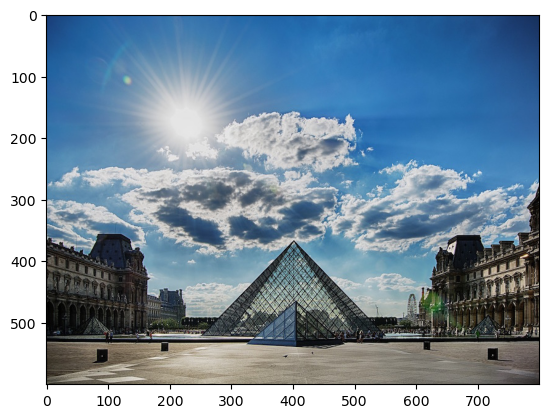

In [8]:
content_image = imageio.imread("images/louvre.jpg")
plt.imshow(content_image);

The content image (C) shows the Louvre museum's pyramid surrounded by old Paris buildings, against a sunny sky with a few clouds.

**3.1.1 - How do you ensure the generated image G matches the content of the image C?**

As we saw in lecture, the earlier (shallower) layers of a ConvNet tend to detect lower-level features such as edges and simple textures, and the later (deeper) layers tend to detect higher-level features such as more complex textures as well as object classes. 

We would like the "generated" image G to have similar content as the input image C. Suppose you have chosen some layer's activations to represent the content of an image. In practice, you'll get the most visually pleasing results if you choose a layer in the middle of the network--neither too shallow nor too deep. (After you have finished this exercise, feel free to come back and experiment with using different layers, to see how the results vary.)

So, suppose you have picked one particular hidden layer to use. Now, set the image C as the input to the pretrained VGG network, and run forward propagation. Let $a^{(C)}$ be the hidden layer activations in the layer you had chosen. (In lecture, we had written this as $a^{[l](C)}$, but here we'll drop the superscript $[l]$ to simplify the notation.) This will be a $n_C \times n_H \times n_W$ tensor. Repeat this process with the image G: Set G as the input, and run forward progation. Let $$a^{(G)}$$ be the corresponding hidden layer activation. We will define as the content cost function as:

$$J_{content}(C,G) =  \frac{1}{4 \times n_C \times n_H \times n_W}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2\tag{1} $$

Here, $n_C, n_H$ and $n_W$ are the number of channels, height and width of the hidden layer you have chosen, and appear in a normalization term in the cost. For clarity, note that $a^{(C)}$ and $a^{(G)}$ are the volumes corresponding to a hidden layer's activations. In order to compute the cost $J_{content}(C,G)$, it might also be convenient to unroll these 3D volumes into a 2D matrix, as shown below. (Technically this unrolling step isn't needed to compute $J_{content}$, but it will be good practice for when you do need to carry out a similar operation later for computing the style const $J_{style}$.)

<img src="images/NST_LOSS.png" style="width:800px;height:400px;">

**Exercise:** Compute the "content cost" using PyTorch. 

**Instructions**: The 3 steps to implement this function are:
1. Retrieve dimensions from a_G.
2. Unroll a_C and a_G as explained in the picture above.
3. Compute the content cost.

In [4]:
# GRADED FUNCTION: compute_content_cost

def compute_content_cost(a_C, a_G):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, C, H, W), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, C, H, W), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    
    ### START CODE HERE ###
    # Retrieve dimensions from a_G (≈1 line)
    m, H, W, C = a_G.shape
    
    # Reshape a_C and a_G (≈2 lines)
    a_C_unrolled = a_C.view(C, -1) #(C, H*W)
    a_G_unrolled = a_G.view(C, -1) #(C, H*W)
    
    # compute the cost with PyTorch (≈1 line)
    J_content = torch.mean((a_C_unrolled - a_G_unrolled)**2)/4
    ### END CODE HERE ###
    
    return J_content

In [5]:
a_C = np.array([-1.683445, 1.8942857, 4.189092, 1.3846824, 3.8925915, 2.3524866, -1.9202449, 4.6461368, -1.0375276, 4.899456, -7.5360813, 3.4091651, -0.24858844, -2.4324749, 8.146585, -1.7646906, 2.4694333, -6.5859847, 0.7149899, 0.66104376, 4.199985, 2.5062335, 4.5016236, 1.5636368, 3.4233422, -8.455175, 3.4438267, 1.2252892, 0.23202246, 1.4615504, 4.211294, -4.7429867, -2.338422, 1.3776655, -3.3965898, 0.25865, 1.2512636, 7.4767985, 5.1221766, 10.617524, -1.3393097, 0.99052405, -5.4103217, -5.450125, -1.7732203, -4.097825, 4.843958, 2.7449985])
a_C = torch.tensor(a_C.reshape([1, 4, 4, 3]).transpose([0, 3, 1, 2]))
a_G = np.array([-0.39043474, -4.965909, -5.387548, 4.572505, 1.1961036, 5.0099816, 1.7304354, -0.13603461, -0.7514645, -3.0110965, 1.0130516, 7.4561086, 0.51901615, -0.23328066, -0.8221154, 0.69788367, 1.5624137, 0.11127031, 3.7990131, -0.5115707, -5.364818, -4.8868036, -1.1914248, -0.12090659, 7.0109277, -1.2259245, 4.2369, -5.399742, 3.159936, 7.259596, 1.643039, 7.3115473, 0.17630118, -2.8375332, 1.839904, -0.71492875, 5.2510543, 1.4054474, 2.8612938, 2.5214956, 4.3172836, 1.902338, 0.14868057, -1.2611487, -0.78171515, 0.5315, -0.8009285, 3.4972606])
a_G = torch.tensor(a_G.reshape([1, 4, 4, 3]).transpose([0, 3, 1, 2]))
J_content = compute_content_cost(a_C, a_G)
print(f'J_content = {J_content}')

J_content = 6.765592868805971


**Expected Output**:

<table>
    <tr>
        <td>
            <b>J_content</b>
        </td>
        <td>
           6.765592868805971
        </td>
    </tr>

</table>

<font color='blue'>
<b>What you should remember</b>:

- The content cost takes a hidden layer activation of the neural network, and measures how different $a^{(C)}$ and $a^{(G)}$ are. 

- When we minimize the content cost later, this will help make sure $G$ has similar content as $C$.

### 3.2 - Computing the style cost

For our running example, we will use the following style image: 

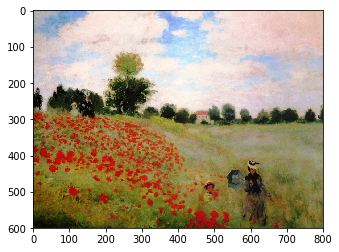

In [6]:
style_image = imageio.imread("images/monet_800600.jpg")
plt.imshow(style_image);

This painting was painted in the style of *[impressionism](https://en.wikipedia.org/wiki/Impressionism)*.

Lets see how you can now define a "style" const function $J_{style}(S,G)$. 

### 3.2.1 - Style matrix

The style matrix is also called a "Gram matrix." In linear algebra, the Gram matrix G of a set of vectors $(v_{1},\dots ,v_{n})$ is the matrix of dot products, whose entries are ${\displaystyle G_{ij} = v_{i}^T v_{j} = np.dot(v_{i}, v_{j})  }$. In other words, $G_{ij}$ compares how similar $v_i$ is to $v_j$: If they are highly similar, you would expect them to have a large dot product, and thus for $G_{ij}$ to be large. 

Note that there is an unfortunate collision in the variable names used here. We are following common terminology used in the literature, but $G$ is used to denote the Style matrix (or Gram matrix) as well as to denote the generated image $G$. We will try to make sure which $G$ we are referring to is always clear from the context. 

In NST, you can compute the Style matrix by multiplying the "unrolled" filter matrix with their transpose:

<img src="images/NST_GM.png" style="width:900px;height:300px;">

The result is a matrix of dimension $(n_C,n_C)$ where $n_C$ is the number of filters. The value $G_{ij}$ measures how similar the activations of filter $i$ are to the activations of filter $j$. 

One important part of the gram matrix is that the diagonal elements such as $G_{ii}$ also measures how active filter $i$ is. For example, suppose filter $i$ is detecting vertical textures in the image. Then $G_{ii}$ measures how common  vertical textures are in the image as a whole: If $G_{ii}$ is large, this means that the image has a lot of vertical texture. 

By capturing the prevalence of different types of features ($G_{ii}$), as well as how much different features occur together ($G_{ij}$), the Style matrix $G$ measures the style of an image. 

**Exercise**:
Using PyTorch, implement a function that computes the Gram matrix of a matrix A. The formula is: The gram matrix of A is $G_A = AA^T$. 

In [7]:
# GRADED FUNCTION: gram_matrix

def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (C, H*W)
    
    Returns:
    GA -- Gram matrix of A, of shape (C, C)
    """
    
    ### START CODE HERE ### (≈1 line)
    GA = torch.mm(A, A.t())
    ### END CODE HERE ###
    
    return GA

In [8]:
torch.random.manual_seed(1)
A = torch.tensor([-1.683445, 1.8942857, 4.189092, 1.3846824, 3.8925915, 2.3524866]).view(3, 2*1)
GA = gram_matrix(A)
print(f'GA =\n {GA}')

GA =
 tensor([[ 6.4223, -4.4291, -2.0967],
        [-4.4291, 19.4658, 19.5639],
        [-2.0967, 19.5639, 20.6865]])


**Expected Output**:

<table>
    <tr>
        <td>
            <b>GA</b>
        </td>
        <td>
           tensor([[  6.4223,  -4.4291,  -2.0967] <br>
 [ -4.4291,  19.4658,  19.5639] <br>
 [ -2.0967,  19.5639,  20.6865]])
        </td>
    </tr>

</table>

### 3.2.2 - Style cost

After generating the Style matrix (Gram matrix), your goal will be to minimize the distance between the Gram matrix of the "style" image S and that of the "generated" image G. For now, we are using only a single hidden layer $a^{[l]}$, and the corresponding style cost for this layer is defined as: 

$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{ij} - G^{(G)}_{ij})^2\tag{2} $$

where $G^{(S)}$ and $G^{(G)}$ are respectively the Gram matrices of the "style" image and the "generated" image, computed using the hidden layer activations for a particular hidden layer in the network.  


**Exercise**: Compute the style cost for a single layer. 

**Instructions**: The 3 steps to implement this function are:
1. Retrieve dimensions from the hidden layer activations a_G. 
2. Unroll the hidden layer activations a_S and a_G into 2D matrices, as explained in the picture above.
3. Compute the Style matrix of the images S and G. (Use the function you had previously written.) 
4. Compute the Style cost.

In [9]:
# GRADED FUNCTION: compute_layer_style_cost

def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, C, H, W), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, C, H, W), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    ### START CODE HERE ###
    # Retrieve dimensions from a_G (≈1 line)
    N, C, H, W = a_G.shape
    
    # Reshape the images to have them of shape (C, H*W) (≈2 lines)
    a_S_unrolled = a_S.view(C, -1)
    a_G_unrolled = a_G.view(C, -1)
    
    # Computing gram_matrices for both images S and G (≈2 lines)
    GS = gram_matrix(a_S_unrolled)
    GG = gram_matrix(a_G_unrolled)
    
    # Computing the loss (≈1 line)
    J_style_layer = torch.sum((GS - GG)**2)/(4 * C**2 * (H*W)**2)
    
    ### END CODE HERE ###
    
    return J_style_layer

In [10]:
torch.random.manual_seed(1)
a_S = np.array([-1.683445, 1.8942857, 4.189092, 1.3846824, 3.8925915, 2.3524866, -1.9202449, 4.6461368, -1.0375276, 4.899456, -7.5360813, 3.4091651, -0.24858844, -2.4324749, 8.146585, -1.7646906, 2.4694333, -6.5859847, 0.7149899, 0.66104376, 4.199985, 2.5062335, 4.5016236, 1.5636368, 3.4233422, -8.455175, 3.4438267, 1.2252892, 0.23202246, 1.4615504, 4.211294, -4.7429867, -2.338422, 1.3776655, -3.3965898, 0.25865, 1.2512636, 7.4767985, 5.1221766, 10.617524, -1.3393097, 0.99052405, -5.4103217, -5.450125, -1.7732203, -4.097825, 4.843958, 2.7449985])
a_S = torch.tensor(a_S.reshape([1, 4, 4, 3]).transpose([0, 3, 1, 2]))
a_G = np.array([-0.39043474, -4.965909, -5.387548, 4.572505, 1.1961036, 5.0099816, 1.7304354, -0.13603461, -0.7514645, -3.0110965, 1.0130516, 7.4561086, 0.51901615, -0.23328066, -0.8221154, 0.69788367, 1.5624137, 0.11127031, 3.7990131, -0.5115707, -5.364818, -4.8868036, -1.1914248, -0.12090659, 7.0109277, -1.2259245, 4.2369, -5.399742, 3.159936, 7.259596, 1.643039, 7.3115473, 0.17630118, -2.8375332, 1.839904, -0.71492875, 5.2510543, 1.4054474, 2.8612938, 2.5214956, 4.3172836, 1.902338, 0.14868057, -1.2611487, -0.78171515, 0.5315, -0.8009285, 3.4972606])
a_G = torch.tensor(a_G.reshape([1, 4, 4, 3]).transpose([0, 3, 1, 2]))
J_style_layer = compute_layer_style_cost(a_S, a_G)
print(f'J_style_layer = {J_style_layer}')

J_style_layer = 9.190277771775303


**Expected Output**:

<table>
    <tr>
        <td>
            <b>J_style_layer</b>
        </td>
        <td>
            9.190277771775303
        </td>
    </tr>

</table>

### 3.2.3 Style Weights

So far you have captured the style from only one layer. We'll get better results if we "merge" style costs from several different layers. After completing this exercise, feel free to come back and experiment with different weights to see how it changes the generated image $G$. But for now, this is a pretty reasonable default: 

In [11]:
print(model)
style_layers = [0, 5, 10, 19, 28]
style_layer_coeffs = [0.2, 0.2, 0.2, 0.2, 0.2]

VGG19_StyleTransfer(
  (features): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17

You can combine the style costs for different layers as follows:

$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$

where the values for $\lambda^{[l]}$ are given in `STYLE_LAYERS`. 


In [12]:
def compute_style_cost(style_layers, style_layer_coeffs, generated_im_results, style_im_results):
    """
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # initialize the overall style cost
    J_style = 0

    for layer_num, coeff in zip(style_layers, style_layer_coeffs):
        # Compute style_cost for the current layer
        a_S = style_im_results[layer_num]
        a_G = generated_im_results[layer_num]
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        # Add coeff * J_style_layer of this layer to overall style cost
        J_style += coeff * J_style_layer

    return J_style


<b>What you should remember</b>:

- The style of an image can be represented using the Gram matrix of a hidden layer's activations. However, we get even better results combining this representation from multiple different layers. This is in contrast to the content representation, where usually using just a single hidden layer is sufficient.

- Minimizing the style cost will cause the image $G$ to follow the style of the image $S$. 



### 3.3 - Defining the total cost to optimize

Finally, let's create a cost function that minimizes both the style and the content cost. The formula is: 

$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$

**Exercise**: Implement the total cost function which includes both the content cost and the style cost. 

In [13]:
def get_costs(model, content_im_results, style_im_results, style_layers, style_layer_coeffs, content_layer, generated_image):
    generated_im_results = model(generated_image)
    
    #Compute content cost
    a_C = content_im_results[content_layer]
    a_G = generated_im_results[content_layer]
    J_content = compute_content_cost(a_C, a_G)
    
    J_style = compute_style_cost(style_layers, style_layer_coeffs, generated_im_results, style_im_results)
    
    return J_content, J_style

In [14]:
# GRADED FUNCTION: total_cost

def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    
    ### START CODE HERE ### (≈1 line)
    J = alpha*J_content + beta*J_style
    ### END CODE HERE ###
    
    return J

**What you should remember**:
- The total cost is a linear combination of the content cost $J_{content}(C,G)$ and the style cost $J_{style}(S,G)$
- $\alpha$ and $\beta$ are hyperparameters that control the relative weighting between content and style

## 4 - Solving the optimization problem

Let's load, reshape, and normalize our "content" image (the Louvre museum picture):

In [15]:
content_image = imageio.imread("images/louvre_small.jpg")
content_image = reshape_and_normalize_image(content_image)

Let's load, reshape and normalize our "style" image

In [16]:
style_image = imageio.imread("images/monet.jpg")
style_image = reshape_and_normalize_image(style_image)

Now, we initialize the "generated" image as a noisy image created from the content_image. By initializing the pixels of the generated image to be mostly noise but still slightly correlated with the content image, this will help the content of the "generated" image more rapidly match the content of the "content" image. (Feel free to look in `nst_utils.py` to see the details of `generate_noise_image(...)`; to do so, click "File-->Open..." at the upper-left corner of this Jupyter notebook.)

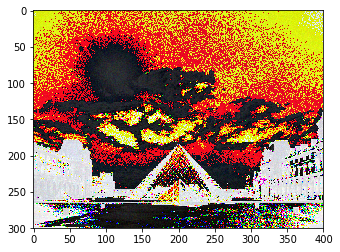

In [17]:
generated_image = generate_noise_image(content_image)
plt.imshow(np.transpose(generated_image, (0, 2, 3, 1))[0].astype(np.uint8));

Let's load the VGG16 model.

In [18]:
content_layer = 21
model = VGG19_StyleTransfer(layers=style_layers + [content_layer])
content_image = torch.tensor(content_image).float().to(device)
style_image = torch.tensor(style_image).float().to(device)
generated_image = torch.tensor(generated_image).float().to(device)
model = model.to(device)

In [19]:
optimizer = optim.Adam([generated_image.requires_grad_()], lr=2.0)

In [20]:
content_im_results = model(content_image)
style_im_results = model(style_image)

In [21]:
for layer in content_im_results.keys():
    content_im_results[layer] = content_im_results[layer].detach()
    style_im_results[layer] = style_im_results[layer].detach()

In [22]:
params = {
    'model': model,
    'style_layers': style_layers,
    'style_layer_coeffs': style_layer_coeffs,
    'content_layer': content_layer,
    'generated_image': generated_image,
    'content_im_results': content_im_results,
    'style_im_results': style_im_results
}

In [23]:
def train(model, style_layers, style_layer_coeffs, content_layer, generated_image,
          content_im_results, style_im_results, num_iterations=200):
    
    for i in range(num_iterations):
        # Print every 20 iteration.
        Jc, Js = get_costs(model, content_im_results, style_im_results, style_layers, style_layer_coeffs, content_layer, generated_image)
        optimizer.zero_grad()
        Jt = total_cost(Jc, Js)
        Jt.backward()
        optimizer.step()
        if i%50 == 0:
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt.item()))
            print("content cost = " + str(Jc.item()))
            print("style cost = " + str(Js.item()))
            
            # save current generated image in the "/output" directory
            save_image("output/" + str(i) + ".png", generated_image)
    
    # save last generated image
    save_image('output/generated_image.jpg', generated_image)

In [24]:
def save_image(path, image):
    # Un-normalize the image so that it looks good
    image = image.detach().cpu().numpy().transpose(0, 2, 3, 1)
    image += CONFIG.MEANS
    image = np.clip(image[0], 0, 255).astype('uint8')
    
    imageio.imsave(path, image)

In [25]:
train(**params, num_iterations=200);

Iteration 0 :
total cost = 315544000.0
content cost = 1182.9925537109375
style cost = 7888304.0
Iteration 50 :
total cost = 25720558.0
content cost = 2454.027587890625
style cost = 642400.4375
Iteration 100 :
total cost = 15869859.0
content cost = 2608.5322265625
style cost = 396094.34375
Iteration 150 :
total cost = 12640786.0
content cost = 2684.658935546875
style cost = 315348.46875


### References:

The Neural Style Transfer algorithm was due to Gatys et al. (2015).

- Leon A. Gatys, Alexander S. Ecker, Matthias Bethge, (2015). A Neural Algorithm of Artistic Style (https://arxiv.org/abs/1508.06576) 
- Harish Narayanan, Convolutional neural networks for artistic style transfer. https://harishnarayanan.org/writing/artistic-style-transfer/
- Karen Simonyan and Andrew Zisserman (2015). Very deep convolutional networks for large-scale image recognition (https://arxiv.org/pdf/1409.1556.pdf)
- https://github.com/chenyuntc/pytorch-book/blob/master/chapter8-%E9%A3%8E%E6%A0%BC%E8%BF%81%E7%A7%BB(Neural%20Style)/PackedVGG.py